# Predicting Wildfire Impact: Overcoming Challenges in Portugal’s Forest Data

In this data science project, our objective is to predict the area affected by forest fires in the northeast region of Portugal, a notoriously challenging regression problem. We employ a linear regression framework, enhanced by feature selection and regularization methods, and compare its performance with a K-nearest neighbors (KNN) approach. Our benchmark is the naive mean predictor, serving as a baseline against which to measure improvements.

Our methodology encompasses log-transforming the response variable to mitigate heavy skewness toward zero, followed by the application of various stepwise selection techniques to optimize the feature set. Despite experimenting with advanced techniques including Lasso, Ridge regression, PCA, and KNN, our results indicate only marginal enhancements over the naive benchmark. The best performing model was obtained using forward stepwise selection applied to a second-degree polynomial transformation, which slightly surpassed the baseline metrics.

The outcome of this analysis revealed that while our most effective model exhibited a moderate reduction in error rates, with a Mean Squared Error (MSE) of 1.94 and a Mean Absolute Error (MAE) of 1.13, it represents only a nominal advancement over the naive mean predictor. This suggests the necessity for alternative modeling strategies, such as a two-step approach integrating classification and regression or exploring non-parametric models, to more robustly tackle the complexities of predicting forest fire areas.

Dataset: https://archive.ics.uci.edu/dataset/162/forest+fires

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [64]:
fires = pd.read_csv('forestfires.csv')

fires

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.00
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.00
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.00
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.00
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,aug,sun,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,6.44
513,2,4,aug,sun,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,54.29
514,7,4,aug,sun,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,11.16
515,1,4,aug,sat,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,0.00


## Data Processing

In [65]:
fires.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X       517 non-null    int64  
 1   Y       517 non-null    int64  
 2   month   517 non-null    object 
 3   day     517 non-null    object 
 4   FFMC    517 non-null    float64
 5   DMC     517 non-null    float64
 6   DC      517 non-null    float64
 7   ISI     517 non-null    float64
 8   temp    517 non-null    float64
 9   RH      517 non-null    int64  
 10  wind    517 non-null    float64
 11  rain    517 non-null    float64
 12  area    517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


There are no missing values, all data types seem to be correctly specified.

Next we will one-hot encode categorical features (month, day).

In [66]:
fires2 = pd.get_dummies(fires, drop_first=True).copy()

fires2

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,month_may,month_nov,month_oct,month_sep,day_mon,day_sat,day_sun,day_thu,day_tue,day_wed
0,7,5,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,0,0,0,0,0,0
1,7,4,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,1,0,0,0,0,0,1,0
2,7,4,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,1,0,0,1,0,0,0,0
3,8,6,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,0,0,0,0,0,0
4,8,6,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
512,4,3,81.6,56.7,665.6,1.9,27.8,32,2.7,0.0,...,0,0,0,0,0,0,1,0,0,0
513,2,4,81.6,56.7,665.6,1.9,21.9,71,5.8,0.0,...,0,0,0,0,0,0,1,0,0,0
514,7,4,81.6,56.7,665.6,1.9,21.2,70,6.7,0.0,...,0,0,0,0,0,0,1,0,0,0
515,1,4,94.4,146.0,614.7,11.3,25.6,42,4.0,0.0,...,0,0,0,0,0,1,0,0,0,0


In [67]:
# Selecting predictors and response variables
X = fires2.drop(['area'], axis=1)
y = fires2['area']

### Log transforming the response

We will explore the distribution of the target variable.

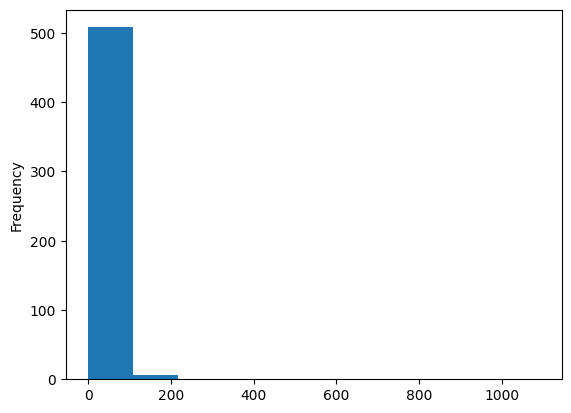

In [68]:
y.plot.hist()
plt.show()

The distribution of the repsonse is heavily skewed towards zero, so it might make sense to log transform it to improve prediction.

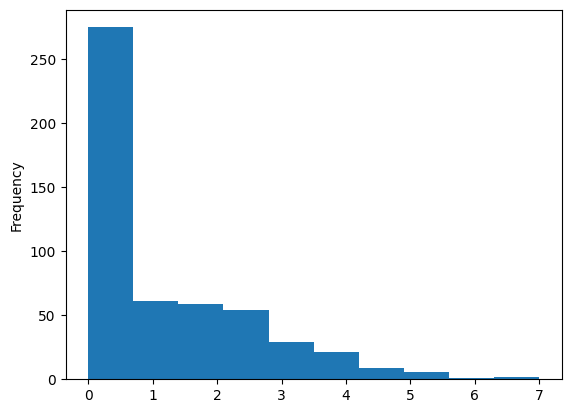

In [69]:
y_log = np.log(y + 1)

y_log.plot.hist()
plt.show()

### Exploring the Features

We will visualize the distribution of features with the help of boxplots.

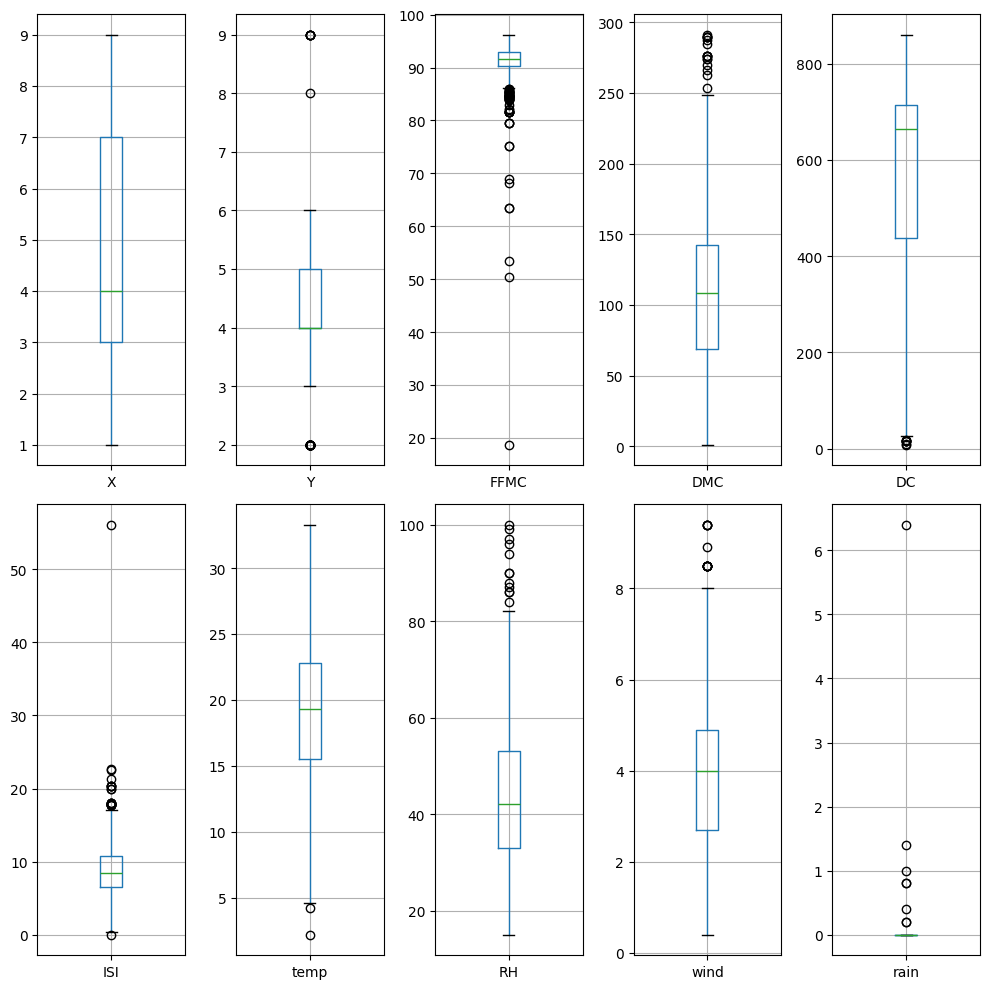

In [70]:
# Selecting features' names
features = X.columns.values.tolist()

# Plotting the distribution
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10,10))

for feature, i in zip(features[:10], range(10)):
    if i <= 4:
        X.boxplot(column=feature, ax=axes[0,i])
    else:
        X.boxplot(column=feature, ax=axes[1,(i-5)])
        
plt.tight_layout()

plt.show()

Almost all features tend to be scattered with a number of potential outliers. Since the dataset contains a limited number of observations (517) and we do not have the deep domain knowledge, we will keep all observations.

Next, we will standardize the features.

In [71]:
from sklearn.preprocessing import StandardScaler

In [72]:
scaler = StandardScaler(with_mean=True,
                        with_std=True,
                        copy=True)
scaler.fit(X)
X_std = scaler.transform(X)

X_std = pd.DataFrame(X_std, columns=features)

### Exploring the Correlations Between Features And the Response

Next we will plot the correlations heatmap.

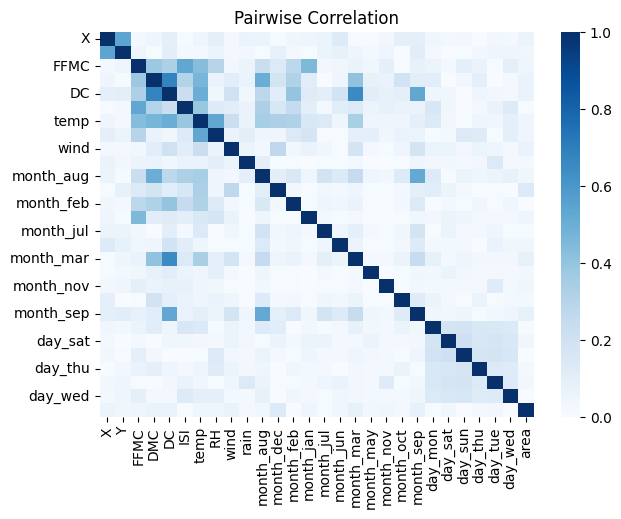

In [73]:
import seaborn as sns

# Plotting the pairwise correlations heatmap
plt.figure(figsize=(7,5))

sns.heatmap(abs(round(pd.concat([X_std, y_log], axis=1).corr(), 2)), cmap='Blues')

plt.title('Pairwise Correlation')

plt.show()

There is a weak correlation between the predictors and the response, and possible collinearity between some predictors, which can pose problems for model building.

## Fitting a Linear Model

First we will fit ordinary least squares model and examine its metrics.

In [74]:
import statsmodels.api as sm

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [75]:
X_std1 = X_std.copy()

# Adding intercept column
X_std1['Intercept'] = 1

# Splitting dataset into training and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_std1, y_log, test_size=0.25, random_state=1000)

# Fitting the model
ols = sm.OLS(y_train1, X_train1)

ols_results = ols.fit()

ols_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   area   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.022
Method:                 Least Squares   F-statistic:                     1.333
Date:                Sun, 05 Nov 2023   Prob (F-statistic):              0.131
Time:                        14:48:33   Log-Likelihood:                -659.57
No. Observations:                 387   AIC:                             1373.
Df Residuals:                     360   BIC:                             1480.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              0.1190      0.084      1.420      0.156      -0.046       0.284
Y             -0.0414      0.087     -0.478      0.633      -0.212       0.129
FFMC          -0.0166      0.118     -0.140      0.888      -0.249       0.216
DMC            0.2458      0.139      1.766      0.078      -0.028       0.520
DC            -0.4444      0.356     -1.248      0.213      -1.145       0.256
ISI           -0.0071      0.115     -0.062      0.951      -0.233       0.219
temp           0.1737      0.154      1.130      0.259      -0.128       0.476
RH            -0.0266      0.120     -0.222      0.825      -0.263       0.209
wind           0.0329      0.082      0.402      0.688      -0.128       0.194
rain           0.0223      0.065      0.340      0.734      -0.106       0.151
month_aug      0.2548      0.434      0.587      0.557      -0.599       1.108
month_dec      0.3315      0.123      2.698      0.007       0.090       0.573
month_feb      0.1433      0.121      1.181      0.238      -0.095       0.382
month_jan     -0.0379      0.082     -0.463      0.644      -0.199       0.123
month_jul      0.0618      0.194      0.318      0.751      -0.321       0.444
month_jun      0.0306      0.131      0.234      0.815      -0.227       0.288
month_mar     -0.0005      0.167     -0.003      0.997      -0.330       0.329
month_may      0.0582      0.069      0.838      0.402      -0.078       0.195
month_nov     -0.0519      0.003    -16.748      0.000      -0.058      -0.046
month_oct      0.1070      0.185      0.577      0.564      -0.258       0.472
month_sep      0.6021      0.484      1.245      0.214      -0.349       1.553
day_mon        0.0203      0.090      0.226      0.821      -0.156       0.197
day_sat        0.1808      0.094      1.914      0.056      -0.005       0.367
day_sun        0.1271      0.099      1.291      0.198      -0.067       0.321
day_thu       -0.0356      0.090     -0.394      0.694      -0.213       0.142
day_tue        0.0578      0.088      0.660      0.509      -0.114       0.230
day_wed        0.0522      0.089      0.588      0.557      -0.122       0.227
Intercept      1.1790      0.070     16.748      0.000       1.041       1.317
==============================================================================
Omnibus:                       45.509   Durbin-Watson:                   2.096
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               58.491
Skew:                           0.937   Prob(JB):                     1.99e-13
Kurtosis:                       3.341   Cond. No.                     1.21e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.69e-30. This might indicate

Low R-squared, high p-values of F-statistic and almost all coefficients indicate that this linear model does not capture the relationship between predictors and response well.

Next we will calculate test error rates and compare them to baseline naive mean predictor.

In [76]:
ols_predictions = ols_results.get_prediction(X_test1)

ols_y_predicted = ols_predictions.predicted_mean

ols_mse = mean_squared_error(ols_y_predicted, y_test1)
ols_mse

2.0769147109799238

In [77]:
ols_mae = mean_absolute_error(ols_y_predicted, y_test1)
ols_mae

1.180427849186803

To benchmark our models, we will compute naive mean predictor on train set and calculate its error rates on test set.

In [78]:
mean_predictor = y_train1.mean()

mean_squared_error([mean_predictor] * y_test1.shape[0], y_test1)

2.001771725369024

In [79]:
mean_absolute_error([mean_predictor] * y_test1.shape[0], y_test1)

1.1847970336733267

Naive mean predictor shows better results than simple linear model.

Now we will try to improve our linear model.

## Model Selection

We will start with forward and backward stepwise selection with 5-fold cross-validation, and then use validation set to assess MSE and MAE.

### Stepwise Selection

In [80]:
import sklearn.linear_model as skl
import sklearn.model_selection as skm

from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

In [81]:
lm = skl.LinearRegression()

# 5-fold CV for selection of optimal hyperparameters
kfold = skm.KFold(n_splits=5,
                     shuffle=True, random_state=1500)

forward_lm = SequentialFeatureSelector(estimator=lm,
                                       n_features_to_select='auto', tol=0.0001,
                                       direction='forward', scoring='neg_mean_squared_error',
                                       cv=kfold)

forward_lm.fit(X_std, y_log)

forward_features = forward_lm.get_feature_names_out()

forward_features

array(['X', 'temp', 'month_dec', 'month_jan', 'month_sep'], dtype=object)

In [82]:
# Validation set for calculating test error rates
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1000)

# Scoring test metrics
scoring_test = ['neg_mean_squared_error', 'neg_mean_absolute_error']

forward_results = skm.cross_validate(lm, X_std[forward_features], y_log, cv=outer_valid,
                            scoring=scoring_test)

forward_results

{'fit_time': array([0.00142002]),
 'score_time': array([0.00089407]),
 'test_neg_mean_squared_error': array([-1.94310593]),
 'test_neg_mean_absolute_error': array([-1.15210753])}

In [83]:
backward_lm = SequentialFeatureSelector(estimator=lm,
                                       n_features_to_select='auto', tol=0.0001,
                                       direction='backward', scoring='neg_mean_squared_error',
                                       cv=kfold)

backward_lm.fit(X_std, y_log)

backward_features = backward_lm.get_feature_names_out()

backward_features

array(['X', 'DMC', 'DC', 'temp', 'month_dec', 'month_jan', 'month_jun',
       'month_mar', 'month_sep'], dtype=object)

In [84]:
backward_results = skm.cross_validate(lm, X_std[backward_features], y_log, cv=outer_valid,
                            scoring=scoring_test)

backward_results

{'fit_time': array([0.00142288]),
 'score_time': array([0.00086117]),
 'test_neg_mean_squared_error': array([-1.94039585]),
 'test_neg_mean_absolute_error': array([-1.14938537])}

In both the forward and backward selections, the X-coordinate, the temperature, and a few months are selected, with the backward selection also including some drought and moisture indicators. Both models give the same MSE of 1.94 and MAE of 1.15.

The stepwise selection models show little improvement over the simple naive predictor.

### Best Subset Selection

In [85]:
from l0bnb import fit_path

In [86]:
X_std2 = np.asarray(X_std)
y_log2 = np.asarray(y_log)

X_train, X_test, y_train, y_test = train_test_split(X_std2, y_log2, test_size=0.25, random_state=1000)

path = fit_path(X_train, y_train, max_nonzeros=25)

Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  1
Iteration: 3. Number of non-zeros:  1
Iteration: 4. Number of non-zeros:  1
Iteration: 5. Number of non-zeros:  1
Iteration: 6. Number of non-zeros:  1
Iteration: 7. Number of non-zeros:  1
Iteration: 8. Number of non-zeros:  1
Iteration: 9. Number of non-zeros:  1
Iteration: 10. Number of non-zeros:  1
Iteration: 11. Number of non-zeros:  1
Iteration: 12. Number of non-zeros:  1
Iteration: 13. Number of non-zeros:  1
Iteration: 14. Number of non-zeros:  1
Iteration: 15. Number of non-zeros:  1
Iteration: 16. Number of non-zeros:  7
Iteration: 17. Number of non-zeros:  7
Iteration: 18. Number of non-zeros:  7
Iteration: 19. Number of non-zeros:  7
Iteration: 20. Number of non-zeros:  7
Iteration: 21. Number of non-zeros:  7
Iteration: 22. Number of non-zeros:  7
Iteration: 23. Number of non-zeros:  7
Iteration: 24. Number of non-zeros:  7
Iteration: 25. Number of non-zeros:  7
I

In [87]:
bss_mse = []
bss_mae = []
bss_non_zero = []
bss_lambda0 = []

for i in path:
    intercept = i['B0']
    b_estimated = i['B']
    lambda_0 = i['lambda_0']
    
    y_estimated = np.dot(X_test, b_estimated) + intercept
    
    mse = mean_squared_error(y_estimated, y_test)
    mae = mean_absolute_error(y_estimated, y_test)
    
    bss_mse.append(mse)
    bss_mae.append(mae)
    
    bss_non_zero.append(np.count_nonzero(b_estimated))
    
    bss_lambda0.append(lambda_0)
    
bss_results = pd.DataFrame()

bss_results['mse'] = bss_mse
bss_results['mae'] = bss_mae
bss_results['non_zero'] = bss_non_zero
bss_results['lambda0'] = bss_lambda0

bss_results

,mse,mae,non_zero,lambda0
0,1.958218,1.158727,1,0.008857
1,1.958218,1.158727,1,0.007790
2,1.958218,1.158727,1,0.007400
3,1.958218,1.158727,1,0.007030
4,1.958218,1.158727,1,0.006679
5,1.958218,1.158727,1,0.006345
6,1.958218,1.158727,1,0.006027
7,1.958218,1.158727,1,0.005726
8,1.958218,1.158727,1,0.005440
9,1.958218,1.158727,1,0.005168


In [88]:
path[0]

{'B': array([0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.19528739, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ]),
 'B0': 1.1744349891893666,
 'lambda_0': 0.008857034701723138,
 'M': 0.13244680544271673,
 'Time_exceeded': False}

It is interesting to note that the model selects only one feature, month of December, which has the highest correlation with the response (see the correlation matrix above), and this model results in only slightly worse MSE of 1.96 and MAE of 1.16 than complex models selected by forward and backward selection.

Next, we apply ridge and lasso regularization.

### Ridge

In [89]:
# Setting up the grid of 100 lambdas from 10^8 to 10^-2 scaled by the standard deviation of the response
lambdas = 10**np.linspace(8, -2, 100) / y_log.std()

ridge = skl.RidgeCV(alphas=lambdas,
                           cv=kfold, scoring='neg_mean_squared_error')
ridge.fit(X_std, y_log)

ridge_results = skm.cross_validate(ridge, 
                             X_std,
                             y_log,
                             cv=outer_valid,
                             scoring=scoring_test)

ridge_results

{'fit_time': array([0.91344833]),
 'score_time': array([0.00094485]),
 'test_neg_mean_squared_error': array([-1.99002816]),
 'test_neg_mean_absolute_error': array([-1.18032885])}

### Lasso

In [90]:
lasso = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold)
lasso.fit(X_std, y_log)

lasso.coef_

array([ 0.02752031,  0.        ,  0.        ,  0.02739207,  0.        ,
       -0.        ,  0.0388734 , -0.        ,  0.00799109,  0.        ,
       -0.        ,  0.14703771,  0.        , -0.        ,  0.        ,
       -0.        , -0.00401133,  0.        , -0.        , -0.        ,
        0.05743194, -0.        ,  0.        ,  0.        , -0.        ,
        0.        , -0.        ])

In [91]:
pd.Series(features)[((lasso.coef_ > 0) | (lasso.coef_ < 0)).tolist()]

0             X
3           DMC
6          temp
8          wind
11    month_dec
16    month_mar
20    month_sep
dtype: object

Lasso selected features similar to those of backward selection.

In [92]:
lasso_results = skm.cross_validate(lasso, 
                             X_std,
                             y_log,
                             cv=outer_valid,
                             scoring=scoring_test)

lasso_results

{'fit_time': array([0.06507707]),
 'score_time': array([0.00236487]),
 'test_neg_mean_squared_error': array([-1.97898422]),
 'test_neg_mean_absolute_error': array([-1.17200722])}

Both lasso and ridge showed only slightly better results than our benchmark.

Next we apply Principal Component Analysis to out linear model.

### PCA

In [93]:
from sklearn.decomposition import PCA

In [94]:
# Setting the grid of 27 components to cross-validate upon
param_grid = {'pca__n_components': range(1, 28)}

pca = PCA()

pipe = Pipeline([('pca', pca),
                 ('lm', lm)])

grid = skm.GridSearchCV(pipe,
                        param_grid,
                        cv=kfold,
                        scoring='neg_mean_squared_error')
grid.fit(X_std, y_log)

grid.best_params_

{'pca__n_components': 12}

In [95]:
# Selecting the oprimal number of components (12) as specified by CV
pca = PCA(n_components=12)

pca_results = skm.cross_validate(pipe, 
                             X_std,
                             y_log,
                             cv=outer_valid,
                             scoring=scoring_test)

pca_results

{'fit_time': array([0.00644183]),
 'score_time': array([0.00128222]),
 'test_neg_mean_squared_error': array([-2.08081075]),
 'test_neg_mean_absolute_error': array([-1.18372596])}

PCA with 12 components selected by CV did not improve the error rates.

Next, we will implement polynomials to try to capture possible non-linear relationships between predictors and response.

### Polynomial (Stepwise, Ridge, Lasso)

In [96]:
from sklearn.preprocessing import PolynomialFeatures

In [97]:
# Creating 2nd degree polynomial
poly = PolynomialFeatures(degree=2, include_bias=False).set_output(transform='pandas')

# Transforming non-binary features
X_poly = poly.fit_transform(X_std.iloc[:,:10])

X_poly2 = pd.concat([X_poly, X_std.iloc[:,10:]], axis=1)

In [98]:
features2 = X_poly2.columns.values.tolist()

# Rescaling the features
scaler.fit(X_poly2)

X_poly_std = scaler.transform(X_poly2)

X_poly_std = pd.DataFrame(X_poly_std, columns=features2)

In [99]:
forward_poly = SequentialFeatureSelector(estimator=lm,
                                       n_features_to_select='auto', tol=0.0001,
                                       direction='forward', scoring='neg_mean_squared_error',
                                       cv=kfold)

forward_poly.fit(X_poly_std, y_log)

forward_poly_features = forward_poly.get_feature_names_out()

forward_poly_results = skm.cross_validate(lm, X_poly_std[forward_poly_features],
                                           y_log, cv=outer_valid, scoring=scoring_test)

forward_poly_results

{'fit_time': array([0.0015707]),
 'score_time': array([0.00085402]),
 'test_neg_mean_squared_error': array([-1.94427969]),
 'test_neg_mean_absolute_error': array([-1.12829613])}

In [100]:
forward_poly_features

array(['X', 'temp', 'X DC', 'X wind', 'Y DC', 'Y ISI', 'Y RH', 'FFMC DMC',
       'FFMC DC', 'FFMC ISI', 'temp^2', 'month_dec', 'month_sep',
       'day_mon', 'day_tue'], dtype=object)

Polynomial model with 15 features selected by forward stepwise selection yields the best results so far, with test MSE of 1.94 and MAE of 1.13.

In [101]:
backward_poly = SequentialFeatureSelector(estimator=lm,
                                       n_features_to_select='auto', tol=0.0001,
                                       direction='backward', scoring='neg_mean_squared_error',
                                       cv=kfold)

backward_poly.fit(X_poly_std, y_log)

backward_poly_features = backward_poly.get_feature_names_out()

backward_poly_results = skm.cross_validate(lm, X_poly_std[backward_poly_features],
                                           y_log, cv=outer_valid, scoring=scoring_test)

backward_poly_results

{'fit_time': array([0.01059794]),
 'score_time': array([0.00153899]),
 'test_neg_mean_squared_error': array([-3.28702583]),
 'test_neg_mean_absolute_error': array([-1.38202374])}

In [102]:
backward_poly_features

array(['X', 'Y', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind', 'rain',
       'X^2', 'X Y', 'X FFMC', 'X DMC', 'X DC', 'X temp', 'X RH',
       'X wind', 'X rain', 'Y^2', 'Y FFMC', 'Y DMC', 'Y DC', 'Y ISI',
       'Y temp', 'Y RH', 'Y wind', 'FFMC^2', 'FFMC DMC', 'FFMC DC',
       'FFMC ISI', 'FFMC temp', 'FFMC RH', 'FFMC wind', 'FFMC rain',
       'DMC^2', 'DMC DC', 'DMC ISI', 'DMC temp', 'DMC RH', 'DMC wind',
       'DMC rain', 'DC^2', 'DC ISI', 'DC temp', 'DC RH', 'DC wind',
       'ISI^2', 'ISI temp', 'ISI RH', 'ISI wind', 'ISI rain', 'temp^2',
       'temp RH', 'temp wind', 'temp rain', 'RH^2', 'RH wind', 'RH rain',
       'wind^2', 'wind rain', 'rain^2', 'month_aug', 'month_dec',
       'month_feb', 'month_jan', 'month_jul', 'month_jun', 'month_mar',
       'month_may', 'month_nov', 'month_oct', 'month_sep', 'day_mon',
       'day_sat', 'day_sun', 'day_thu', 'day_tue', 'day_wed'],
      dtype=object)

Polynomial model with backward-selected features selects too many predictors and shows significantly worse results.

In [103]:
ridge_poly = skl.RidgeCV(alphas=lambdas,
                           cv=kfold, scoring='neg_mean_squared_error')

ridge_poly.fit(X_poly_std, y_log)

ridge_poly_results = skm.cross_validate(ridge_poly, 
                             X_poly_std,
                             y_log,
                             cv=outer_valid,
                             scoring=scoring_test)

ridge_poly_results

{'fit_time': array([1.50366282]),
 'score_time': array([0.00114822]),
 'test_neg_mean_squared_error': array([-1.99494349]),
 'test_neg_mean_absolute_error': array([-1.17386699])}

In [104]:
lasso_poly = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1,
                           cv=kfold,
                           max_iter=10000)

lasso_poly.fit(X_poly_std, y_log)

lasso_poly_results = skm.cross_validate(lasso_poly, 
                             X_poly_std,
                             y_log,
                             cv=outer_valid,
                             scoring=scoring_test)

lasso_poly_results

{'fit_time': array([1.550735]),
 'score_time': array([0.00352883]),
 'test_neg_mean_squared_error': array([-1.9900728]),
 'test_neg_mean_absolute_error': array([-1.17881502])}

The regularized polynom did not show improved results.

Next, we try nonparametric KNN regression.

### KNN

In [105]:
from sklearn.neighbors import KNeighborsRegressor

In [106]:
knn = KNeighborsRegressor()

# Setting up the grid of possible hyperparameters to cross-validate upon
parameters = {'n_neighbors' : np.arange(1, 25, 1),
              'weights': ['uniform', 'distance'],
              'algorithm' : ['ball_tree', 'kd_tree', 'brute'],
              'p' : [1, 2, 3, 4, 5]}

gs_knn = skm.GridSearchCV(knn, parameters, cv=kfold, scoring='neg_mean_squared_error')

gs_knn.fit(X_std, y_log)

gs_knn.best_params_

{'algorithm': 'brute', 'n_neighbors': 23, 'p': 3, 'weights': 'uniform'}

In [107]:
knn = KNeighborsRegressor(algorithm='brute', n_neighbors=23, p=3, weights='uniform')

knn_results = skm.cross_validate(knn, 
                             X_std,
                             y_log,
                             cv=outer_valid,
                             scoring=scoring_test)

knn_results

{'fit_time': array([0.00140429]),
 'score_time': array([0.01356792]),
 'test_neg_mean_squared_error': array([-2.07432981]),
 'test_neg_mean_absolute_error': array([-1.20440209])}

KNN also shows worse results than benchmark.

## Comparing the Performance

Now we can visually compare the resulted error rates of each model.

In [108]:
summary_errors = pd.DataFrame(columns=['OLS', 'Best Subset', 'Backward', 'Forward',
                          'Ridge', 'Lasso', 'PCA', 'Forward Poly', 'Backward Poly',
                          'Ridge Poly', 'Lasso Poly', 'KNN'],
                             index=['MSE', 'MAE'])

# Selecting results for simple linear model
summary_errors['OLS'] = [ols_mse, ols_mae]

# Selecting the results of best subset selection
summary_errors['Best Subset'] = [bss_results.iloc[0]['mse'], bss_results.iloc[0]['mae']]

summary_errors

,OLS,Best Subset,Backward,Forward,Ridge,Lasso,PCA,Forward Poly,Backward Poly,Ridge Poly,Lasso Poly,KNN
MSE,2.076915,1.958218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAE,1.180428,1.158727,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [109]:
results_all = [backward_results, forward_results,
               ridge_results, lasso_results, pca_results,
               forward_poly_results, backward_poly_results,
               ridge_poly_results, lasso_poly_results, knn_results]

# Selecting the results of the remaining models
for result, col in zip(results_all, summary_errors.columns[2:]):
    mse = -result['test_neg_mean_squared_error'][0]
    mae = -result['test_neg_mean_absolute_error'][0]
    
    summary_errors[col] = [mse, mae]
    
summary_errors

,OLS,Best Subset,Backward,Forward,Ridge,Lasso,PCA,Forward Poly,Backward Poly,Ridge Poly,Lasso Poly,KNN
MSE,2.076915,1.958218,1.940396,1.943106,1.990028,1.978984,2.080811,1.944280,3.287026,1.994943,1.990073,2.074330
MAE,1.180428,1.158727,1.149385,1.152108,1.180329,1.172007,1.183726,1.128296,1.382024,1.173867,1.178815,1.204402


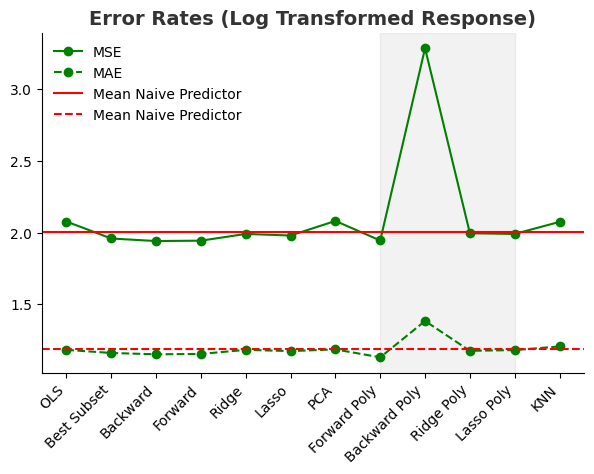

In [110]:
# Visualizing the test error rates of all models
fig, ax = plt.subplots(figsize=(7,5))

ax.plot(summary_errors.columns, summary_errors.T['MSE'], marker='o', label='MSE', c='g')
ax.plot(summary_errors.columns, summary_errors.T['MAE'], marker='o', label='MAE', c='g', ls='--')

ax.axvspan(xmin='Forward Poly', xmax='Lasso Poly',
           alpha=0.1, color='grey')

# Baseline mean predictors MSE and MAE
ax.axhline(mean_squared_error([mean_predictor] * y_test1.shape[0], y_test1), c='r', label='Mean Naive Predictor')
ax.axhline(mean_absolute_error([mean_predictor] * y_test1.shape[0], y_test1), c='r', ls='--',
           label='Mean Naive Predictor')

ax.set_title('Error Rates (Log Transformed Response)', weight='bold', alpha=0.8, size=14)

ax.spines[['right', 'top']].set_visible(False)

ax.legend(frameon=False)

fig.autofmt_xdate(rotation=45)

plt.show()

As shown in the graph, most models show small to zero improvement over the naive mean predictor's MSE (2.0) and MAE (1.18). The best result was achieved with forward stepwise selection on a 2nd degree polynomial model with 15 features (MSE 1.94, MAE 1.13).

We can inverse transform the response and compare the error rates of this model and the baseline error rates on the initial scale (the burned area of the forest, in ha).

## Model Evaluation on Initial Scale

In [111]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X_poly_std[forward_poly_features], y_log,
                                                        test_size=0.25, random_state=1000)
lm = skl.LinearRegression()

lm.fit(X_train3, y_train3)

y_log_pred = lm.predict(X_test3)

y_pred = np.exp(y_log_pred) - 1

y_test4 = np.exp(y_test3) - 1

mean_squared_error(y_test4, y_pred)

4956.171305268326

In [112]:
mean_absolute_error(y_test4, y_pred)

14.229374607003598

In [113]:
y.describe()

count     517.000000
mean       12.847292
std        63.655818
min         0.000000
25%         0.000000
50%         0.520000
75%         6.570000
max      1090.840000
Name: area, dtype: float64

Compared to the mean (12.85) and the standard deviation (63.66) of the response variable, an MAE of 14.2 is relatively low, and our model is performing adequately, especially since the data contains outliers and has a large range. However, the MSE is quite high, which could be heavily influenced by the model's inability to accurately predict the correct area for the larger fires or whatever is causing the outliers. The high MSE indicates that there are some large errors likely due to these outliers.

In [114]:
mean_predictor1 = np.exp(mean_predictor) - 1

mean_squared_error([mean_predictor1] * y_test4.shape[0], y_test4)

4986.54972705317

In [115]:
mean_absolute_error([mean_predictor1] * y_test4.shape[0], y_test4)

14.255817257879155

Overall, the model shows an insignificant improvement over the naive mean predictor on the initial response scale compared to our benchmark.

# Conclusion

In pursuit of predicting the area burned by forest fires in Portugal's northeastern region, this project employed a linear regression model enriched by subset selection and regularization techniques, alongside a KNN model, with the aim of surpassing the predictive power of the naive mean predictor. Our approach involved log-transforming the response variable, optimizing feature selection, and rigorously testing multiple models, including Lasso, Ridge regression, PCA, and KNN, to refine our predictions.

Our most significant findings indicate that the best performing model—a second-degree polynomial regression with carefully selected features—yielded only a slight improvement in predicting fire-affected areas, with a Mean Squared Error of 1.94 and a Mean Absolute Error of 1.13 (log transformed scale). These results suggest that the complex nature of the data limits the effectiveness of traditional linear models and points towards the potential of exploring more sophisticated approaches, such as a two-step modeling process or non-linear methods. Reflecting on these outcomes, it's clear that while we have made modest advancements, there is a compelling need for continued research and the application of innovative techniques in this environmentally and economically critical domain.